<a href="https://colab.research.google.com/github/rahule-1999/DDA-python/blob/main/Week_4/Module_4_1_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


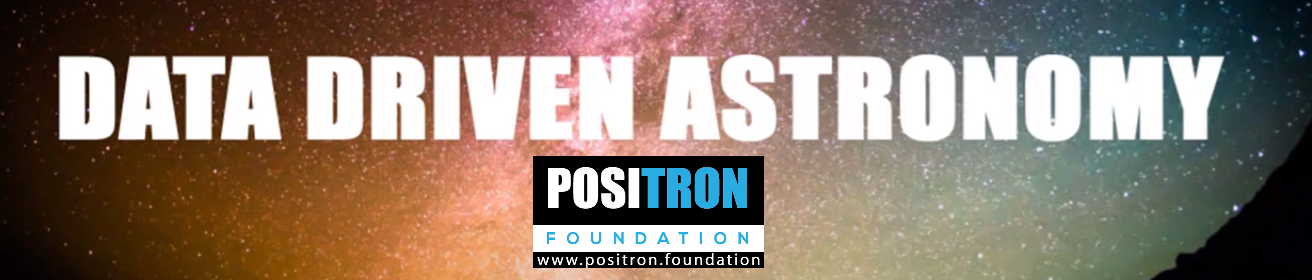




Welcome to **IV week** of **Data Driven Astronomy** Online course organized by **Positron Foundation**

This week we will be learning about how to use Convolutional Neural Network for solving Big Data problem in Astronomy.

The inner workings of a Neural Network is a course in itself. Thus we will be taking a black box approach.

**Change runtime to : GPU**

In [3]:
!pip install -Uqq fastbook
import fastbook

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO as bytesio

In [5]:
from fastai.vision.all import *
from fastbook import *
from fastai.vision.widgets import *
from astropy.io import fits

In [6]:
!git clone https://github.com/Jack3690/DDA

fatal: destination path 'DDA' already exists and is not an empty directory.


In [7]:
cd DDA/Week_4/data

/content/DDA/Week_4/data


# **Star-Galaxy Classification using Convolutional Neural Networks**

## **Data**

'galaxy_cubes.npy.zip' has image data of 10000 stars and galaxies. As a first step we will unzip the data and load it into a numpy array

In [8]:
with zipfile.ZipFile('galaxy_cubes.npy.zip','r') as f:
  file = f.namelist()[0]
  bytes_d = bytesio(f.read(file))
  df = np.load(bytes_d)

In [9]:
print('Size of dataset : ',len(df))

Size of dataset :  10000


'labels.npy' tells us about the label corresponding to each source in 'galaxy_cubes.npy.zip'.

In [10]:
labels = np.load('labels.npy')
labels

array([0., 1., 2., ..., 0., 0., 2.])

In [11]:
np.unique(labels)

array([0., 1., 2.])

We observe that 'labels.npy' has three unique labels. 

0. : Star

1. : Spiral Galaxy

2. : Elliptical Galaxy

In [12]:
classes = {
    0.0 : 'Star',
    1.0 : 'Spiral',
    2.0 : 'Elliptical'
}
type(classes)

dict

In [68]:
# Min-Max feature normalization
def norm(data):
  # Complete code for normalizing to [0,1]
  data = (data - data.min())/(data.max()-data.min())
  return data

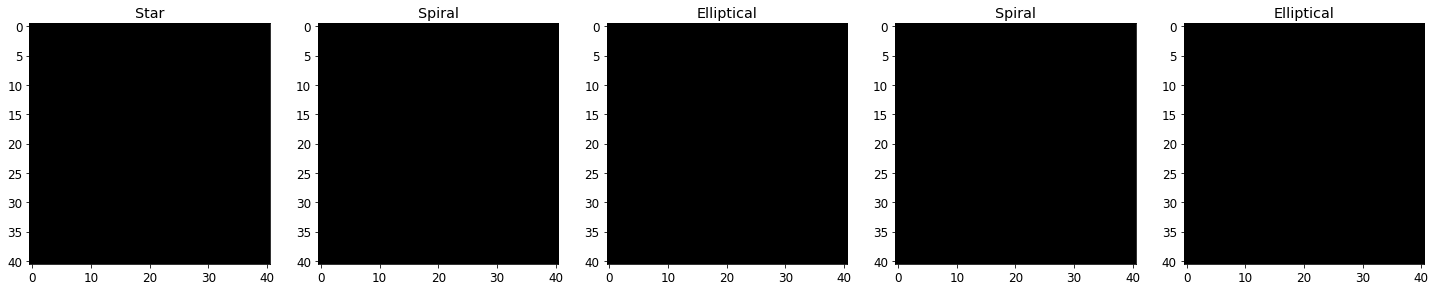

In [14]:
fig,ax = plt.subplots(1,5,figsize=(25,5))
for index, label in enumerate(labels[:5]):
  # Normalize the data in df[index]
  data = df[index]
  data[:,:,0] = norm(data[:,:,0])
  data[:,:,1] = norm(data[:,:,1])
  data[:,:,2] = norm(data[:,:,2])

  ax[index].imshow(data)
  ax[index].set_title(classes[label])

## **Preparation**

We will divide our data into two classes : Star and Galaxy. We could directly load df and labels into Fast.ai modules but we will explore how to prepare data in case it is in image format.

Making folder 'classes' and within it creating folders 'star' and 'galaxy'

In [15]:
!mkdir classes
!mkdir classes/star
!mkdir classes/galaxy

In [16]:
for index, label in enumerate(labels):
  data = df[index]
  data[:,:,0] = norm(data[:,:,0])
  data[:,:,1] = norm(data[:,:,1])
  data[:,:,2] = norm(data[:,:,2])
  if label==0.0:
   plt.imsave(f'classes/star/s{index}.png',data)
  else:
    plt.imsave(f'classes/galaxy/g{index}.png',data)

In [17]:
star = os.listdir('classes/star')
len(star)

3347

In [18]:
galaxy = os.listdir('classes/galaxy')
len(galaxy)

6653

In [19]:
path_out = Path('classes/')
path_out.exists()

True

###**ResNet 18**

ResNet-18 is a convolutional neural network that is 18 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224.

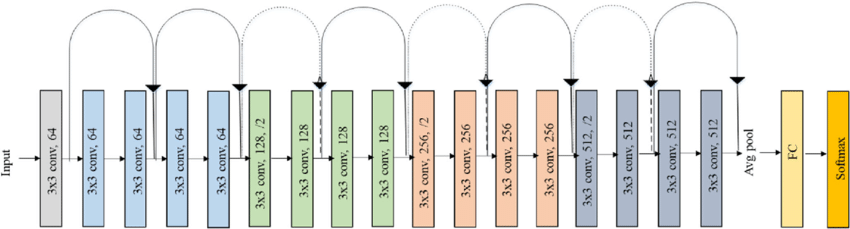

##**Model**

In [20]:
# Creating image block and splitting data into training and validation set. 80% training and 20% validation
galaxy = DataBlock(blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, splitter=RandomSplitter(valid_pct=0.2, seed=42), get_y = parent_label)

In [21]:
# Loading Data
dls = galaxy.dataloaders(path_out)

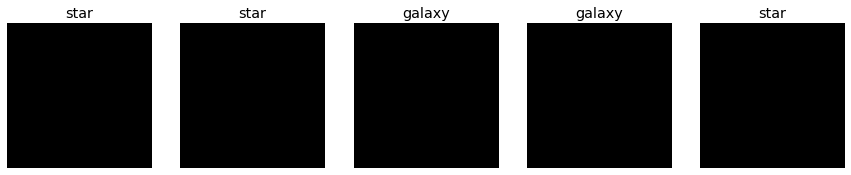

In [22]:
# Showing validation set
dls.valid.show_batch(max_n=5, nrows=1)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.712354,0.638648,0.664500,00:24


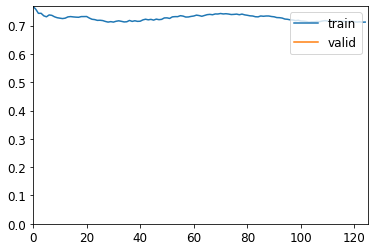

In [23]:
# Learner with resnet18 architecure with pretrained=False,cbs=ShowGraphCallback,metrics=accuracy
learn = cnn_learner(dls,resnet18, pretrained=False,cbs=ShowGraphCallback,metrics=accuracy)
# Fit using fit_one_cycle with 1 iterations
learn.fit_one_cycle(1)

##**Using Data Augmentation**

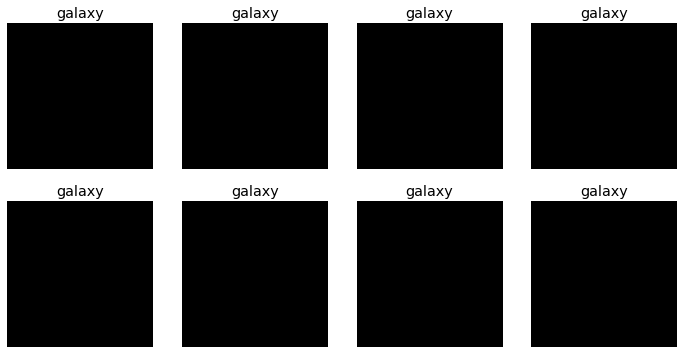

In [24]:
# Using Data Augmentation and plotting the sample of training batch. Use the settings below for all data augmentation in this module
galaxy = galaxy.new(batch_tfms=aug_transforms(mult=2, flip_vert=True),item_tfms=RandomResizedCrop(224, min_scale=0.5),)
dls = galaxy.dataloaders(path_out)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.708029,0.684662,0.664500,00:14


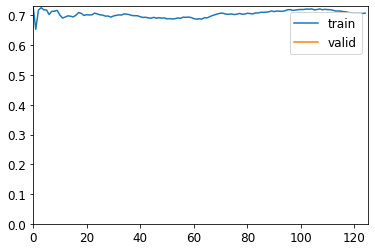

epoch,train_loss,valid_loss,accuracy,time
0,0.656464,0.638487,0.664500,00:13


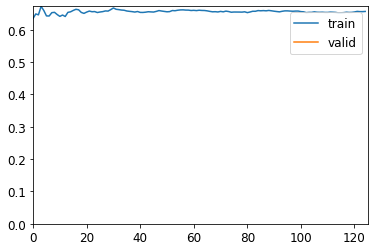

In [25]:
# Fit using fine_tune with 1 iterations
learn.fine_tune(1)

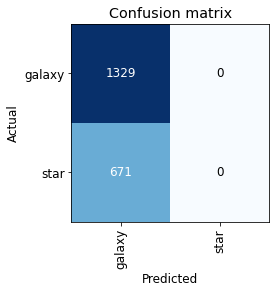

In [26]:
# Plotting Confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

##**Testing(Optional)**

Upload image of a galaxy or star named 'test.png' for testing. Use image with resolution less than 128x128 pixels

In [27]:
img = Image.open('/content/DDA/Week_4/data/test.png')
img

FileNotFoundError: ignored

In [ ]:
learn.predict('/content/DDA/Week_4/data/test.png')

#**Galaxy Zoo Data**

In [28]:
!mkdir /root/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [29]:
cp -a kaggle.json /root/.kaggle/

In [30]:
!chmod 600 /root/.kaggle/kaggle.json

In [31]:
import kaggle
import zipfile
import pandas as pd

In [32]:
!kaggle competitions download -c galaxy-zoo-the-galaxy-challenge

100% 1.77G/1.77G [00:45<00:00, 44.3MB/s]
100% 1.77G/1.77G [00:45<00:00, 41.7MB/s]


In [33]:
!unzip galaxy-zoo-the-galaxy-challenge.zip

Archive:  galaxy-zoo-the-galaxy-challenge.zip
  inflating: all_ones_benchmark.zip  
  inflating: all_zeros_benchmark.zip  
  inflating: central_pixel_benchmark.zip  
  inflating: images_test_rev1.zip    
  inflating: images_training_rev1.zip  
  inflating: training_solutions_rev1.zip  


In [34]:
with zipfile.ZipFile('images_training_rev1.zip','r') as f:
  f.extractall()
with zipfile.ZipFile('training_solutions_rev1.zip','r') as f:
  f.extractall()

In [35]:
len(os.listdir('images_training_rev1'))

61578

In [36]:
df_labels = pd.read_csv('training_solutions_rev1.csv')

In [37]:
df_labels

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.000000,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.00000,0.027227,0.000000,0.027227,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.000000,0.000000,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.000000,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.00000,0.000000,0.140353,0.000000,0.048796,0.000000,0.000000,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.000000,0.000000,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.000000,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.000000,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.00000,0.000000,0.096119,0.096119,0.000000,0.128159,0.000000,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.000000,0.000000,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.029383,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61573,999948,0.510379,0.489621,0.000000,0.059207,0.430414,0.000000,0.430414,0.226257,0.204157,0.043458,0.260804,0.000000,0.126152,0.245734,0.754266,0.000000,0.410816,0.099563,0.03514,0.000000,0.000000,0.000000,0.175454,0.035140,0.000000,0.059207,0.0,0.000000,0.226257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.226257
61574,999950,0.901216,0.098784,0.000000,0.000000,0.098784,0.000000,0.098784,0.000000,0.098784,0.000000,0.045378,0.053406,0.000000,0.127644,0.872356,0.404841,0.496375,0.000000,0.00000,0.000000,0.021321,0.000000,0.062095,0.044229,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
61575,999958,0.202841,0.777376,0.019783,0.116962,0.660414,0.067245,0.593168,0.140022,0.520391,0.000000,0.257128,0.347328,0.055958,0.839186,0.160814,0.030477,0.172364,0.000000,0.00000,0.000000,0.033567,0.134270,0.067135,0.604214,0.000000,0.116962,0.0,0.000000,0.000000,0.090673,0.049349,0.000000,0.067726,0.000000,0.000000,0.0,0.072296
61576,999964,0.091000,0.909000,0.000000,0.045450,0.863550,0.022452,0.841098,0.795330,0.068220,0.000000,0.227114,0.545764,0.090673,0.864000,0.136000,0.045500,0.045500,0.000000,0.09072,0.000000,0.090720,0.136512,0.045792,0.500256,0.000000,0.045450,0.0,0.000000,0.068398,0.318132,0.408799,0.227464,0.408799,0.090668,0.023065,0.0,0.045334


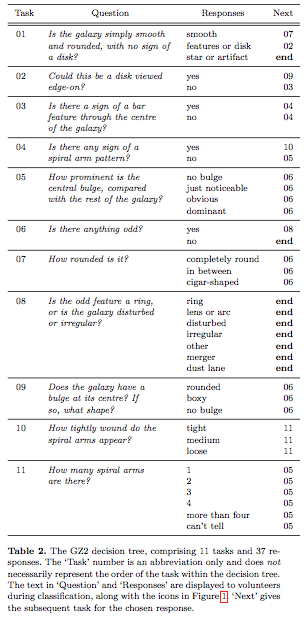

Figure 7.1

Let's make dataframes containing Spiral galaxies and Elliptical galaxies


# **Morphology Classifier with Two Classes**

**Exercise 7.1.a**

Use the following conditions for creating sample of spiral galaxies and elliptical galaxies using df_labels. Refer figure 7.1 to find out what each condition means

**Spiral**

'Class1.2'>0.5

'Class2.2'>0.8

'Class4.1'>0.5


'Class8.6'==0

**Elliptical**

'Class1.1'>0.5

'Class7.1'>0.8

'Class8.6'==0

##**Data**

In [ ]:
df_spiral     = df_labels[(df_labels['Class1.2']>0.5) & (df_labels['Class2.2']>0.8)  & (df_labels['Class4.1']>0.5)& (df_labels['Class8.6']==0)]
df_elliptical = df_labels[(df_labels['Class1.1']>0.5) & (df_labels['Class7.1']>0.5) & (df_labels['Class8.6']==0)] 

len(df_spiral), len(df_elliptical)

(5109, 5775)

Compare models by training the data with different sample sizes

1) 200

2) 500

3) 1000

In [ ]:
sample_size = 1000  # Edit this line for changing sample size

df_spiral = df_spiral[:sample_size]

df_elliptical = df_elliptical[:sample_size]

len(df_elliptical),len(df_spiral)

(1000, 1000)

In [ ]:
# Plotting sample images using df_spiral from images_training_rev1/
fig,ax = plt.subplots(1,5, figsize = (25,5))
c = 0
for i in df_spiral['GalaxyID'][:5]:
  img = plt.imread(f'images_training_rev1/{i}.jpg')
  ax[c].imshow(img)
  ax[c].set_xlabel('Spiral')
  c+=1

In [ ]:
# Plotting sample images using df_elliptical from images_training_rev1/
fig,ax = plt.subplots(1,5, figsize = (25,5))
c = 0
for i in df_elliptical['GalaxyID'][:5]:
  img = plt.imread(f'images_training_rev1/{i}.jpg')
  ax[c].imshow(img)
  ax[c].set_xlabel('Elliptical')
  c+=1

##**Preparation**

Making folder 'morph' and within it creating folders 'spiral' and 'elliptical'

In [ ]:
# Directory containing images based on class
!mkdir morph
!mkdir morph/spiral
!mkdir morph/elliptical

Copying images to respective class folders based on tables (df_elliptical and df_spiral)

In [ ]:
# Copying images from images_training_rev1/ to morph/spiral/ using df_spiral
for i in df_spiral['GalaxyID']:
  os.system(f'cp images_training_rev1/{i}.jpg  morph/spiral/')

In [ ]:
# Copying images from images_training_rev1/ to morph/elliptical/ using df_elliptical
for i in df_elliptical['GalaxyID']:
  os.system(f'cp images_training_rev1/{i}.jpg  morph/elliptical/')

In [ ]:
# Checking number of sources in the directories 'morph/spiral' and 'morph/elliptical'
len(os.listdir('morph/spiral')), len(os.listdir('morph/elliptical'))

In [ ]:
# Setting path_out to 'morph/'
path_out = Path('morph/')
path_out.exists()

##**Model**

In [ ]:
# Creating image block and splitting data into training and validation set. 80% training and 20% validation
galaxy = DataBlock(blocks=(ImageBlock, CategoryBlock),get_items=get_image_files, splitter=RandomSplitter(valid_pct=0.2, seed=42), get_y = parent_label,item_tfms=Resize(128))

In [ ]:
# Load Data
dls = galaxy.dataloaders(path_out)

In [ ]:
# Show validation set
dls.valid.show_batch(max_n=4, nrows=1)

**Transfer learning**

Transfer learning (TL) is a research problem in machine learning (ML) that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. [Learn more](https://en.wikipedia.org/wiki/Transfer_learning)

We will use a **pretrained network**

In [ ]:
# Learner with resnet101 architecure with pretrained=True,cbs=ShowGraphCallback,metrics=accuracy
learn = cnn_learner(dls, resnet101, pretrained=True, cbs=ShowGraphCallback, metrics=accuracy)

# Fit using fit_one_cycle with 10 iterations



##**Use Data Augmentation**

In [ ]:
# Use Data Augmentation and plot the sample of training batch



In [ ]:
# Fit using fit_one_cycle with 10 iterations


In [ ]:
# Plot Confusion Matrix
interp = 

We see how sample size affects accuracy of the CNN model. We also notice that Pretrained model allows us to train a high accuracy CNN model with just 2000 samples

# **Morphology Classifier with three classes**

Let's add one more class

**Lenticular**

'Class1.2'>0.5

'Class2.2'>0.5

'Class4.2'>0.5

'Class3.2'>0.5

'Class8.6'==0

##**Data**

In [13]:
df_spiral     = df_labels[(df_labels['Class1.2']>0.5) & (df_labels['Class2.2']>0.8)  & (df_labels['Class4.1']>0.5) & (df_labels['Class8.6']==0)]
df_elliptical = df_labels[(df_labels['Class1.1']>0.5) & (df_labels['Class7.1']>0.5) & (df_labels['Class8.6']==0)] 
df_lenticular = df_labels[(df_labels['Class1.2']>0.5) & (df_labels['Class2.2']>0.5)  & (df_labels['Class4.2']>0.5) & (df_labels['Class8.6']==0)] 


len(df_spiral), len(df_lenticular), len(df_elliptical)

NameError: ignored

In [ ]:
sample_size = 2000  

df_spiral = df_spiral[:sample_size]

# Complete the code below
df_lenticular = 

df_elliptical =

len(df_spiral), len(df_lenticular), len(df_elliptical)

(2000, 2000, 2000)

In [ ]:
# Plot sample images using df_spiral from images_training_rev1/





In [ ]:
# Plot sample images using df_lenticular from images_training_rev1/




In [ ]:
# Plot sample images using df_elliptical from images_training_rev1/





##**Preparation**

Make subfolder lenticular inside the folder morph

In [ ]:
# Directory containing images based on class



In [ ]:
# Copying images from images_training_rev1/ to morph/spiral/ using df_spiral
for i in df_spiral['GalaxyID']:
  os.system(f'cp images_training_rev1/{i}.jpg  morph/spiral/')

In [ ]:
# Copying images from images_training_rev1/ to morph/lenticular/ using df_lenticular
for i in df_lenticular['GalaxyID']:
  os.system(f'cp images_training_rev1/{i}.jpg  morph/lenticular/')

In [ ]:
# Copying images from images_training_rev1/ to morph/elliptical using df_elliptical
for i in df_elliptical['GalaxyID']:
  os.system(f'cp images_training_rev1/{i}.jpg  morph/elliptical/')

In [ ]:
# Check number of sources in the directories 'morph/spiral', 'morph/lenticular' and 'morph/elliptical'



In [ ]:
# Set path_out to 'morph/'
path_out = 
path_out.exists()

True

##**Model**


In [ ]:
# Creating image block and splitting data into training and validation set. 80% training and 20% validation
galaxy = 

In [ ]:
# Load Data
dls = 

In [ ]:
# Plot Validation set


**Pretrained Network**

In [ ]:
# Learner with resnet152 architecure with pretrained=False,cbs=ShowGraphCallback,metrics=accuracy
learn = 

# Fit using fit_one_cycle with 10 iterations


##**Use Data Augmentation**

In [ ]:
# Use Data Augmentation and plot the sample of training batch



In [ ]:
# Fit using fit_one_cycle with 10 iterations

In [ ]:
# Plot Confusion Matrix
interp = 

We see that Lenticulars and Spirals are more prone to misclassification. Try finding out why?


# **Puzzle VIII**

# **Bar Classifier**

##**Data**

In [38]:
df_spiral     = df_labels[(df_labels['Class1.2']>0.5) & (df_labels['Class2.2']>0.5)  & (df_labels['Class4.1']>0.5)& (df_labels['Class8.6']==0)]

df_spiral_bar = df_spiral[df_spiral['Class3.1']>0.5]

df_spiral_nobar = df_spiral[df_spiral['Class3.2']>0.5]

len(df_spiral_bar), len(df_spiral_nobar)

(1322, 4469)

**Samples from each class**

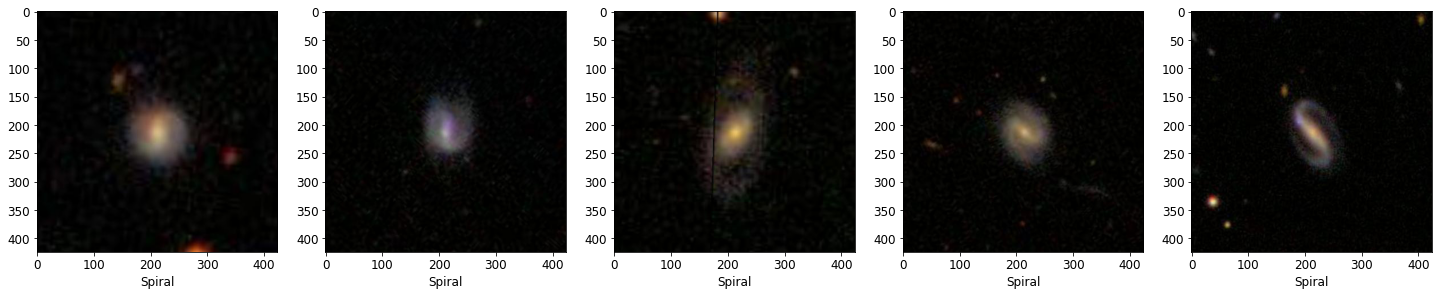

In [39]:
# Plot sample images using df_spiral_bar from images_training_rev1/

fig,ax = plt.subplots(1,5, figsize = (25,5))
c = 0
for i in df_spiral_bar['GalaxyID'][:5]:
  img = plt.imread(f'images_training_rev1/{i}.jpg')
  ax[c].imshow(img)
  ax[c].set_xlabel('Spiral')
  c+=1



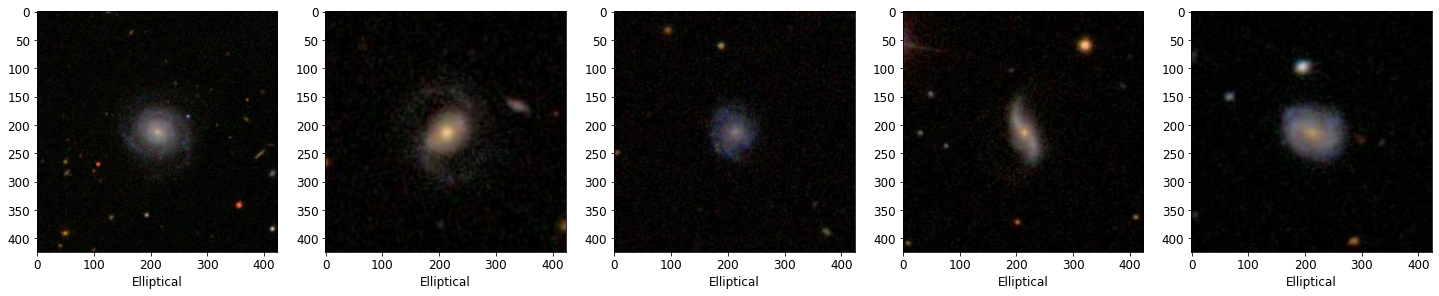

In [40]:
# Plot sample images using df_spiral_nobar from images_training_rev1/
fig,ax = plt.subplots(1,5, figsize = (25,5))
c = 0
for i in df_spiral_nobar['GalaxyID'][:5]:
  img = plt.imread(f'images_training_rev1/{i}.jpg')
  ax[c].imshow(img)
  ax[c].set_xlabel('Elliptical')
  c+=1


##**Preparation**

Make folder 'spiral' and within it create folder 'barred' and 'unbarred'

In [41]:
# Directory containing images based on class
# Directory containing images based on class

!mkdir spiral
!mkdir spiral/barred
!mkdir spiral/unbarred

Copying images to respective class folders based on tables (df_spiral_bar and df_spiral_nobar

In [42]:
# Copy images from images_training_rev1/ to spiral/barred/ using df_spiral_bar
for i in df_spiral_bar['GalaxyID']:
  os.system(f'cp images_training_rev1/{i}.jpg  spiral/barred/')

In [43]:
# Copy images from images_training_rev1/ to spiral/unbarred/ using df_spiral_nobar
for i in df_spiral_nobar['GalaxyID']:
  os.system(f'cp images_training_rev1/{i}.jpg  spiral/unbarred/')

In [44]:
# Check number of sources in the directories 'spiral/barred' and 'spiral/unbarred'
len(os.listdir('spiral/barred')), len(os.listdir('spiral/unbarred'))

(1322, 4469)

In [45]:
# Set path_out to 'spiral/'
path_out = Path('spiral/')
path_out.exists()

True

##**Model**

In [46]:
# Creating image block and splitting data into training and validation set. 60% training and 40% validation
galaxy = DataBlock(blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, splitter=RandomSplitter(valid_pct=0.4, seed=42), get_y = parent_label)

In [47]:
# Load Data
dls = galaxy.dataloaders(path_out)

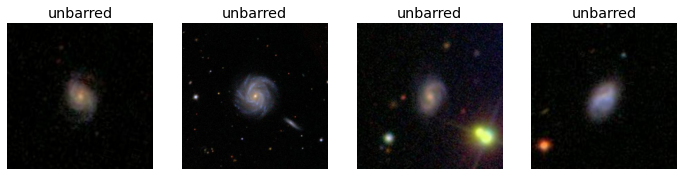

In [48]:
# Show Validation set
dls.valid.show_batch(max_n=4, nrows=1)

In [50]:
# Learner with resnet152 architecure with pretrained=True,cbs=ShowGraphCallback,metrics=accuracy
learn = cnn_learner(dls, resnet152, pretrained=True, cbs=ShowGraphCallback, metrics=accuracy)

# Fit using fit_one_cycle with 10 iterations
#learn.fit_one_cycle(10)

##**Use Data Augmentation**

In [ ]:
# Use Data Augmentation and plot the sample of training batch


In [ ]:
# Fit using fit_one_cycle with 10 iterations


In [ ]:
# Plot Confusion Matrix
interp = 

In [51]:
# Decoder
d = []
for p in learn.model.parameters():  
  if p.data.shape ==(256,256,3,3):
    data = p.data.cpu().detach().numpy()
    d.append(data)

Write code for opening 'puzzle_VIII.fits'

In [62]:
path = fits.open('puzzle_VIII.fits')

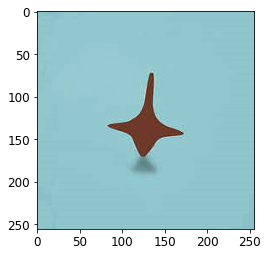

In [69]:
R = path[0].data/d[0][:,:,0,0]
G = path[1].data/d[0][:,:,1,0]
# Complete the missing code
B = path[2].data/d[0][:,:,2,0]


R_norm = norm(R)
G_norm = norm(G)
B_norm = norm(B)
#print(R_norm.shape)
RGB = np.stack([R_norm, G_norm, B_norm],axis =2)

plt.imshow(RGB)